In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


In [3]:
### Data Collection using TIINGO ( this was a good resource i found, i was having some problem with Investing.com) to collect past data of the stock 
import pandas_datareader as pdr
key="8f291cc13ac10b56a0b393bba2debea47ca99268"

In [4]:
df = pdr.get_data_tiingo('AAPL', api_key=key)


/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [5]:
df.to_csv('AAPL.csv')


In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
### since we are going to precdict the closing price of the stock the next day, we will only be using the close price of the stock 

df1 = df.reset_index()['close']

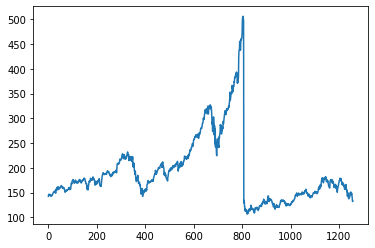

In [8]:
#plotting the data for a better visual 

plt.plot(df1)

In [9]:
df1.shape


(1258,)

In [10]:
### scaling the values if important since LSTM can be sensitive, so using the MinMax scaler and scaling it between 0 and 1  

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

## so here we have completed collecting the data 

In [11]:
## now moving onto preprocessing the data 
## to make the test - train split, since it is a time series data we cannot use cross validation or random seed
## so here i will take a 65 - 35 % train - test split here 

training_size = int (len(df1)*0.65)
test_size = len(df1) - training_size

train_data= df1[0 : training_size , :] 
test_data = df1[training_size : len(df1) , :] 





In [12]:
### Now doing the actual preprocessing
### so now we will be creating timesteps of length 100 

def create_dataset ( dataset , time_step = 1):
  dataX , dataY = [] , []
  for i in range (len(dataset) - time_step - 1 ):
    row = dataset[i : (i + time_step) ,  0 ]
    dataX.append(row)
    dataY.append(dataset[i + time_step , 0])
  
  return np.array(dataX) , np.array(dataY)



In [13]:
time_step = 100; 

X_train , Y_train = create_dataset( train_data , time_step)
X_test , Y_test = create_dataset(test_data, time_step)


In [14]:
### Now creating the LSTM model 

## since LSTM needs another dimension to the input data set, adding it 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
### importing dependencies

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import LSTM

In [16]:
### creating the LSTM model 

model = Sequential()

model.add(LSTM(50, return_sequences = True , input_shape = (time_step , 1)))
model.add(LSTM(50 , return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile( loss = 'mean_squared_error' , optimizer = 'adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
### training the model 

model.fit(X_train , Y_train, validation_data = (X_test , Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 9s 317ms/step - loss: 0.0377 - val_loss: 0.0030
Epoch 2/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0133 - val_loss: 0.0102
Epoch 3/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0108 - val_loss: 0.0015
Epoch 4/100
12/12 [==============================] - 2s 194ms/step - loss: 0.0090 - val_loss: 3.4787e-04
Epoch 5/100
12/12 [==============================] - 2s 194ms/step - loss: 0.0090 - val_loss: 4.4757e-04
Epoch 6/100
12/12 [==============================] - 2s 196ms/step - loss: 0.0084 - val_loss: 7.1619e-04
Epoch 7/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0083 - val_loss: 4.3098e-04
Epoch 8/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0081 - val_loss: 3.4786e-04
Epoch 9/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0081 - val_loss: 3.2808e-04
Epoch 10/100
12/12 [==============================] - 2s 196ms/step

In [19]:
### now predicting on train and test data 

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [20]:
### transforming back to original form 


train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


In [21]:
## calculting the Root mean squared error performance metrics

from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

236.40877030128075

In [22]:
## for the test data

math.sqrt(mean_squared_error(Y_test, test_predict))

147.18142348494274

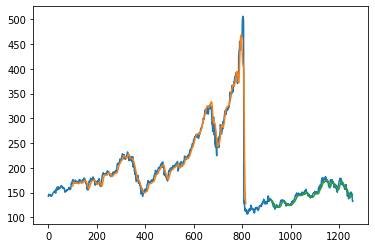

In [24]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
### Now lets use this weapon to predict the future of the stock and trade 
### why stop at next day when we can use it to predict for the whole next month 

len(test_data) # comes out to be 441 so for the last 100 days -> 341 : 
x_input=test_data[ 341:].reshape(1,-1)
x_input.shape

(1, 100)

In [28]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
#  prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
    

[0.08685008]
101
1 day input [0.13720726 0.13259862 0.1323732  0.13119599 0.15902317 0.17016907
 0.16974327 0.17282405 0.16546024 0.16418284 0.16235441 0.1702943
 0.17392611 0.16350657 0.15479023 0.15539136 0.16518472 0.16458359
 0.15539136 0.15143394 0.14396994 0.13332498 0.14001252 0.14529743
 0.1459737  0.14116468 0.14958046 0.14875391 0.14108954 0.13139637
 0.12673763 0.14053851 0.12944271 0.11994991 0.1096556  0.1208516
 0.13212273 0.13470257 0.14311835 0.14662492 0.15524108 0.1587226
 0.16839073 0.17001879 0.17222292 0.1806387  0.17765811 0.16974327
 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667 0.15842204
 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847 0.15168441
 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463 0.12455855
 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793 0.12505949
 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775 0.10086412
 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941 0.09084534
 0.08395742 0.08435817 0.09252348 0.

In [30]:
# plotting the actual data, and the next 30 days' prediction 

day_new=np.arange(1,101)
day_pred=np.arange(101,131)

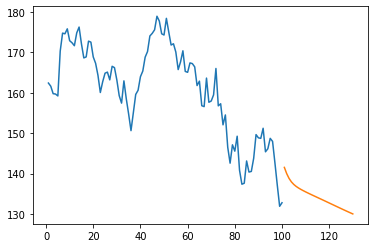

In [31]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))


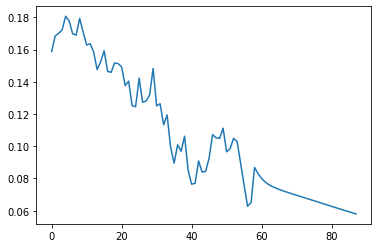

In [32]:
## lets see the combined output also 
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

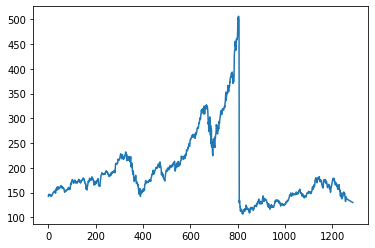

In [33]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

## here is the whole complete graph 